---
title: NerFs for SSH
date: 2023-08-09
subject: Neural Fields for SSH Interpolation
subtitle: Naive Nerfs applied to SSH Data
short_title: Spatiotemporal Data
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: data-assimilation, open-science
abbreviations:
    NerF: Neural Field
---

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import pandas as pd
import keras_core as keras
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
from sklearn.pipeline import Pipeline


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a very simple spatial interpolation problem for sea surface height.

## Data

In [2]:
!ls /Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid/

gf_mod_ssh_daily.nc       gf_obs_nadir.nc.dvc       natl_mod_ssh_daily.nc.dvc
gf_mod_ssh_daily.nc.dvc   gf_obs_nadirswot.nc       natl_mod_sst.nc.dvc
gf_mod_sst.nc             gf_obs_nadirswot.nc.dvc   natl_obs_nadir.nc.dvc
gf_mod_sst.nc.dvc         gf_obs_swot.nc            natl_obs_nadirswot.nc.dvc
gf_obs_nadir.nc           gf_obs_swot.nc.dvc


In [3]:
import xarray as xr
from oceanbench._src.geoprocessing.temporal import time_rescale


xrds = xr.open_dataset("/Volumes/EMANS_HDD/data/oceanbench-data-registry/osse_natl60/grid/gf_mod_ssh_daily.nc")
xrds = xrds.sel(time=slice("2012-10-22","2012-10-28"))
xrds = time_rescale(xrds, freq_dt=1, freq_unit="seconds", t0=None)
xrds

<xarray.Dataset>
Dimensions:  (time: 7, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) float32 0.0 8.64e+04 1.728e+05 ... 4.32e+05 5.184e+05
Data variables:
    ssh      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

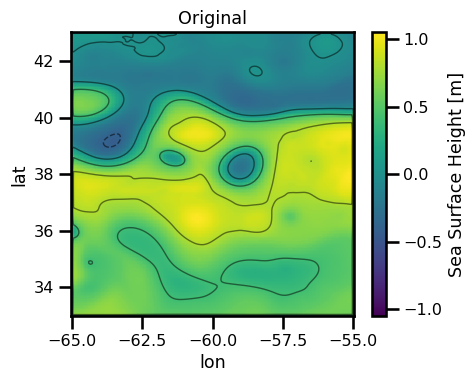

In [4]:
from matplotlib import ticker

fig, ax = plt.subplots(ncols=1, figsize=(5,4))

subset_ds = xrds.ssh.isel(time=-1)

cbar_kwargs = {"label": "Sea Surface Height [m]"}
subset_ds.plot.pcolormesh(ax=ax, cmap="viridis", cbar_kwargs=cbar_kwargs)

loc = ticker.MaxNLocator(5)
levels = loc.tick_values(xrds.ssh.min().values, xrds.ssh.max().values)
subset_ds.plot.contour(
    ax=ax, 
    alpha=0.5, linewidths=1, cmap="black",
    levels=levels,
    linestyles=np.where(levels >= 0, "-", "--")
    # vmin=vmin, vmax=vmax,
    # **kwargs
)   
ax.set(title="Original")

plt.tight_layout()
plt.show()

In [5]:
dfds = xrds["ssh"].to_dataframe().reset_index().dropna()
# apply coordinate transformation
dfds.head()

,time,lat,lon,ssh
0,0.0,33.0,-65.00,0.0
1,0.0,33.0,-64.95,0.0
2,0.0,33.0,-64.90,0.0
3,0.0,33.0,-64.85,0.0
4,0.0,33.0,-64.80,0.0


In [6]:
from nerf4ssh._src.transforms.scaling import MinMaxDF

scaler = MinMaxDF(columns=["lon", "lat", "time"])

x = scaler.fit_transform(dfds).values
y = dfds[["ssh"]].values

In [7]:
x.shape, y.shape

((282807, 3), (282807, 1))

## Model

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

### MLP Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sigma\left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)
$$

where $\sigma$ is the *ReLU* activation function.

$$
\sigma(\mathbf{x}) = \text{ReLU}(\mathbf{x})
$$

In [8]:
# xrda["ssh_pre"] = (("time", "lat", "lon"), dm.data_to_df(out).to_xarray().ssh.data)

In [9]:
from nerf4ssh._src.losses import psnr

In [10]:
input_shape = (3,)
model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(1, activation=None),
    ]
)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)               │        512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:

verbose = 0

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_mlp_spatiotemporal_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=20),
]

In [13]:
# model.save("saved_models/final_model_mlp_.keras", )
# model = keras.saving.load_model("saved_models/final_model_mlp.keras")

In [14]:
batch_size = 32
epochs = 500
warmup_steps = 10
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.1, 
    warmup_steps=warmup_steps,
    warmup_target=1e-3
)

In [15]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [16]:
history_mlp = model.fit(
    x=x, y=y,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/500
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 4s 498us/step - loss: 0.0222 - psnr: 27.0011 - val_loss: 0.0102 - val_psnr: 28.4379
Epoch 2/500
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 4s 440us/step - loss: 0.0063 - psnr: 33.1721 - val_loss: 0.0077 - val_psnr: 29.2991
Epoch 3/500
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 3s 438us/step - loss: 0.0055 - psnr: 34.9507 - val_loss: 0.0072 - val_psnr: 30.6022
Epoch 4/500
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step - loss: 0.0049 - psnr: 36.2814 - val_loss: 0.0060 - val_psnr: 31.5907
Epoch 5/500
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 4s 445us/step - loss: 0.0048 - psnr: inf - val_loss: 0.0056 - val_psnr: 31.1973
Epoch 6/500
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 4s 446us/step - loss: 0.0045 - psnr: 37.4800 - val_loss: 0.0060 - val_psnr: 32.1260
Epoch 7/500
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step - loss: 0.0043 - psnr: 37.9986 - val_loss: 0.0065 - val_psnr: 31.0927
Epoch 8/500
7954/7954 ━━━━━━━━━━━━━━━━━━━━ 3s 439us/step - loss: 0.0043 - psnr: inf - val_loss: 0.0054 - val_psnr: 

In [39]:
# model.save("saved_models/final_model_mlp.keras")

In [40]:
fig, ax = plt.subplots()

ax.plot(history_mlp.epoch, history_mlp.history['loss'], label="Training")
ax.plot(history_mlp.epoch, history_mlp.history['val_loss'], label="Validation")
ax.set(
    title="MLP",
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

TypeError: float() argument must be a string or a real number, not '_NoValueType'

<Figure size 640x480 with 0 Axes>

In [41]:
score = model.evaluate(x=x, y=y, verbose=1)

8838/8838 ━━━━━━━━━━━━━━━━━━━━ 5s 575us/step - loss: 0.0011 - psnr: inf


In [42]:
predictions = model.predict(x=x, verbose=1)

8838/8838 ━━━━━━━━━━━━━━━━━━━━ 1s 113us/step


In [43]:
dfds["ssh_mlp"] = predictions

In [44]:
dfds.head()


ValueError: Only callable can be used as callback

ValueError: Only callable can be used as callback

In [45]:
meta_cols = ["time", "lat", "lon"]
var_cols = ["ssh", "ssh_mlp"]
xrds_ = dfds.reset_index().set_index(meta_cols)[var_cols].to_xarray()

xrds_

TypeError: int() argument must be a string, a bytes-like object or a real number, not '_NoValueType'

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

time = 5
vmin = xrds_.ssh.min()
vmax = xrds_.ssh.max()

xrds_.ssh.isel(time=time).plot.pcolormesh(ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax)
ax[0].set(title="Original")

xrds_.ssh_mlp.isel(time=time).plot.pcolormesh(ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax)
ax[1].set(title="Naive MLP")

np.abs(xrds_.ssh_mlp-xrds_.ssh).isel(time=time).plot.pcolormesh(ax=ax[2], cmap="Reds", vmin=0.0, vmax=1.0)
ax[2].set(title="Error")

plt.tight_layout()
plt.show()

### Random Fourier Features

In [29]:
from nerf4ssh._src.models.rff import RFFLayer

In [30]:
input_shape = (3,)
model_rff = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        RFFLayer(num_features=512, length_scale_train=True),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=1, activation=None),
    ]
)

In [31]:

verbose = 0

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_rff_spatial_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=10),
]

In [32]:
# model.save("saved_models/final_model_mlp_.keras", )
# model = keras.saving.load_model("saved_models/final_model_mlp.keras")

In [33]:
batch_size = 4096
epochs = 500
warmup_steps = 10
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.1, 
    warmup_steps=warmup_steps,
    warmup_target=1e-3
)

In [34]:
model_rff.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [36]:
history_rff = model_rff.fit(
    x=x, y=y,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1707 - psnr: 13.1813 - val_loss: 0.0537 - val_psnr: 19.5324
Epoch 2/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0411 - psnr: 21.6986 - val_loss: 0.0333 - val_psnr: 22.0145
Epoch 3/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0217 - psnr: 25.3981 - val_loss: 0.0176 - val_psnr: 24.8377
Epoch 4/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0114 - psnr: 29.6291 - val_loss: 0.0126 - val_psnr: 26.4332
Epoch 5/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0083 - psnr: 31.2021 - val_loss: 0.0126 - val_psnr: 26.9252
Epoch 6/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0072 - psnr: 32.1020 - val_loss: 0.0109 - val_psnr: 27.6204
Epoch 7/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0067 - psnr: 32.7241 - val_loss: 0.0108 - val_psnr: 27.8400
Epoch 8/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0062 - psnr: 33.3009 - val_loss: 0.0106 - val_psnr: 27.8502
Epoch 9/500
56/56 ━━━━━━

In [87]:
# model.save("saved_models/final_model_mlp.keras")

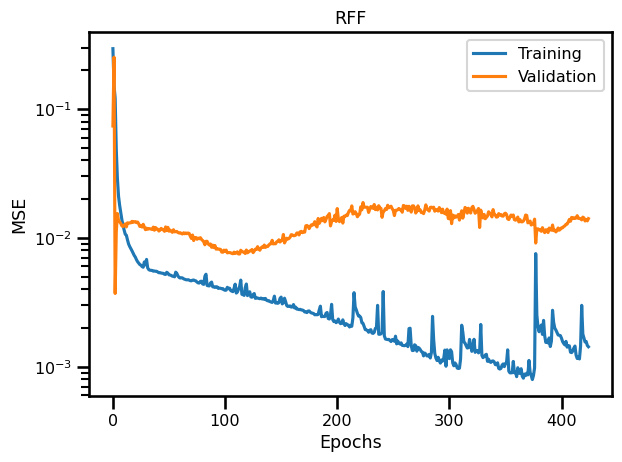

In [88]:
fig, ax = plt.subplots()

ax.plot(history_rff.epoch, history_rff.history['loss'], label="Training")
ax.plot(history_rff.epoch, history_rff.history['val_loss'], label="Validation")
ax.set(
    title="RFF",
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

In [89]:
score = model_rff.evaluate(x=x, y=y, verbose=1)

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0017 - psnr: 43.4109 


In [90]:
predictions = model_rff.predict(x=x)

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step


In [91]:
dfds["ssh_rff"] = predictions

In [92]:
dfds.head()


,time,lat,lon,ssh,ssh_mlp,ssh_rff
0,2012-10-22 12:00:00,33.0,-65.00,0.0,0.409414,-0.045394
1,2012-10-22 12:00:00,33.0,-64.95,0.0,0.440137,-0.036285
2,2012-10-22 12:00:00,33.0,-64.90,0.0,0.457427,-0.028124
3,2012-10-22 12:00:00,33.0,-64.85,0.0,0.470424,-0.020892
4,2012-10-22 12:00:00,33.0,-64.80,0.0,0.481025,-0.014564


In [93]:
meta_cols = ["time", "lat", "lon"]
var_cols = ["ssh", "ssh_mlp", "ssh_rff"]
xrds_ = dfds.reset_index().set_index(meta_cols)[var_cols].to_xarray()

xrds_

<xarray.Dataset>
Dimensions:  (time: 1, lat: 201, lon: 201)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-22T12:00:00
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
Data variables:
    ssh      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ssh_mlp  (time, lat, lon) float32 0.4094 0.4401 0.4574 ... -0.1069 -0.1111
    ssh_rff  (time, lat, lon) float32 -0.04539 -0.03628 ... 0.06555 0.05201

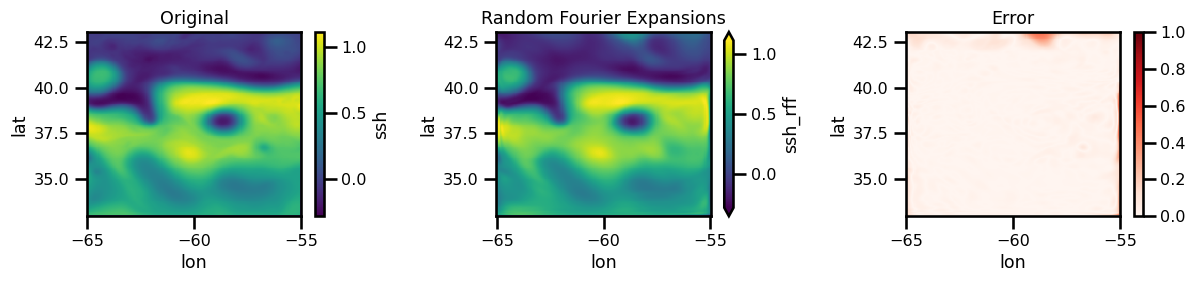

In [94]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

vmin = xrds_.ssh.min()
vmax = xrds_.ssh.max()

xrds_.ssh.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax)
ax[0].set(title="Original")

xrds_.ssh_rff.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax)
ax[1].set(title="Random Fourier Expansions")

np.abs(xrds_.ssh_rff-xrds_.ssh).isel(time=0).plot.pcolormesh(ax=ax[2], cmap="Reds", vmin=0.0, vmax=1.0)
ax[2].set(title="Error")

plt.tight_layout()
plt.show()

### SIREN

In [95]:
from nerf4ssh._src.models.siren import SirenLayer

In [96]:
input_shape = (2,)
c = 6
omega_0 = 30
omega = 1.0
model_siren = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        SirenLayer(units=128, omega=omega_0, c=c, layer_type="first"),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=1, omega=omega, c=c, layer_type="last"),
    ]
)

In [97]:
# model.save("saved_models/final_model_mlp_.keras", )
# model = keras.saving.load_model("saved_models/final_model_mlp.keras")

In [110]:
batch_size = 1024
epochs = 500
warmup_steps = 50
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.1, 
    warmup_steps=warmup_steps,
    warmup_target=1e-3
)

In [111]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_siren_spatial_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50),
]

In [112]:
model_siren.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.AdamW(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [ ]:
history_siren = model_siren.fit(
    x=x, y=y,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.9786e-04 - psnr: 47.1170 - val_loss: 0.1111 - val_psnr: 17.0121
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - psnr: 33.5470 - val_loss: 0.0943 - val_psnr: 17.0749
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - psnr: 32.3386 - val_loss: 0.0857 - val_psnr: 17.7536
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012 - psnr: 36.7364 - val_loss: 0.0822 - val_psnr: 18.1121
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.7671e-04 - psnr: 38.4985 - val_loss: 0.0813 - val_psnr: 18.4463
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3086e-04 - psnr: 40.5600 - val_loss: 0.0801 - val_psnr: 18.6266
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5454e-04 - psnr: 40.1832 - val_loss: 0.0783 - val_psnr: 18.7489
Epoch 8/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5016e-04 - psnr: 43.2469 - val_loss: 0.0782 - val_psnr: 18.7301
Epoc

In [ ]:
# model.save("saved_models/final_model_mlp.keras")

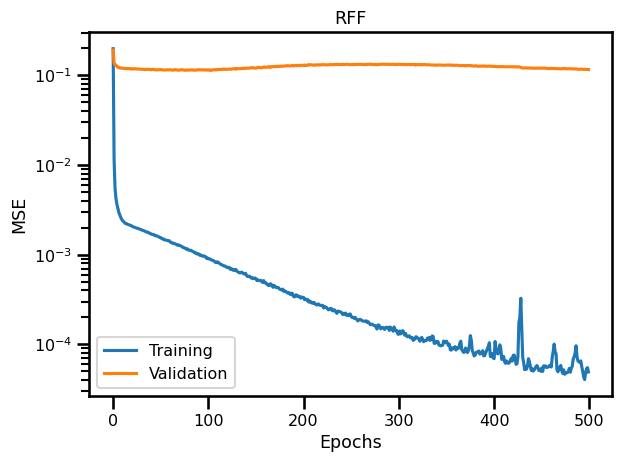

In [103]:
fig, ax = plt.subplots()

ax.plot(history_siren.epoch, history_siren.history['loss'], label="Training")
ax.plot(history_siren.epoch, history_siren.history['val_loss'], label="Validation")
ax.set(
    title="RFF",
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

In [104]:
score = model_siren.evaluate(x=x, y=y, verbose=1)

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - loss: 5.1954e-04 - psnr: 49.3741


In [105]:
predictions = model_siren.predict(x=x)

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


In [106]:
dfds["ssh_siren"] = predictions

In [107]:
dfds.head()


,time,lat,lon,ssh,ssh_mlp,ssh_rff,ssh_siren
0,2012-10-22 12:00:00,33.0,-65.00,0.0,0.409414,-0.045394,-0.073494
1,2012-10-22 12:00:00,33.0,-64.95,0.0,0.440137,-0.036285,0.070833
2,2012-10-22 12:00:00,33.0,-64.90,0.0,0.457427,-0.028124,0.034134
3,2012-10-22 12:00:00,33.0,-64.85,0.0,0.470424,-0.020892,-0.012509
4,2012-10-22 12:00:00,33.0,-64.80,0.0,0.481025,-0.014564,-0.027391


In [108]:
meta_cols = ["time", "lat", "lon"]
var_cols = ["ssh", "ssh_mlp", "ssh_rff", "ssh_siren"]
xrds_ = dfds.reset_index().set_index(meta_cols)[var_cols].to_xarray()

xrds_

<xarray.Dataset>
Dimensions:    (time: 1, lat: 201, lon: 201)
Coordinates:
  * time       (time) datetime64[ns] 2012-10-22T12:00:00
  * lat        (lat) float64 33.0 33.05 33.1 33.15 ... 42.85 42.9 42.95 43.0
  * lon        (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
Data variables:
    ssh        (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ssh_mlp    (time, lat, lon) float32 0.4094 0.4401 0.4574 ... -0.1069 -0.1111
    ssh_rff    (time, lat, lon) float32 -0.04539 -0.03628 ... 0.06555 0.05201
    ssh_siren  (time, lat, lon) float32 -0.07349 0.07083 ... 0.3162 0.3604

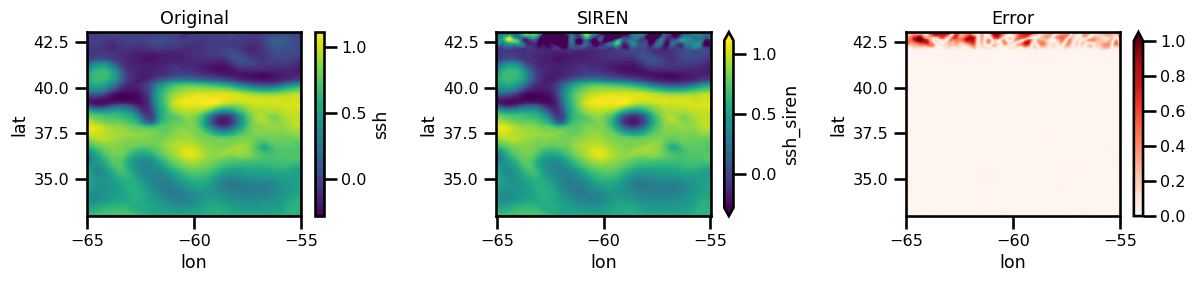

In [109]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

vmin = xrds_.ssh.min()
vmax = xrds_.ssh.max()

xrds_.ssh.isel(time=0).plot.pcolormesh(ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax)
ax[0].set(title="Original")

xrds_.ssh_siren.isel(time=0).plot.pcolormesh(ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax)
ax[1].set(title="SIREN")

np.abs(xrds_.ssh_siren-xrds_.ssh).isel(time=0).plot.pcolormesh(ax=ax[2], cmap="Reds", vmin=0.0, vmax=1.0)
ax[2].set(title="Error")

plt.tight_layout()
plt.show()